In [1]:
from _utils import *
from _polychrom import *
import openmm.testInstallation
openmm.testInstallation.main()

2024-10-25 18:55:37.310674: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 18:55:37.780705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.



OpenMM Version: 8.1.1
Git Revision: Unknown

There are 4 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces
4 OpenCL - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.28573e-06
Reference vs. CUDA: 6.73721e-06
CPU vs. CUDA: 7.34139e-07
Reference vs. OpenCL: 6.73115e-06
CPU vs. OpenCL: 7.3891e-07
CUDA vs. OpenCL: 1.74379e-07

All differences are within tolerance.


In [2]:
'''
 Polymer simulations
 This version implements simulations of Cohesin-mediated loop extrusion and heterotypic chromatin interactions.
 This script reads in 15 variable parameters from a text file.  The parameter text file is typically produced programatically, since parameters that specify all the CTCF sites, for example, are quite long arrays. 
'''

# Not sure why cuda does not work here

import sys

import os
import pickle 
import numpy as np
import numpy.matlib
import h5py
import ast
import pandas as pd
import math

from LEBondUpdater import bondUpdater

import polychrom
from polychrom.starting_conformations import grow_cubic
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
from polychrom.simulation import Simulation
from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
import time

from tqdm.auto import tqdm
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))  # This prevents crash on GPU


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pyBigWig

# Open the BigWig file
ctcf_bw_esc = pyBigWig.open('/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/chip_seq_paper/GSM4773203_H9_ESC_CTCF_ChIPseq_replicate2.scale.bw')
ctcf_bw_cncc = pyBigWig.open('/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/chip_seq_paper/GSM4773208_H9_P4CNCC_CTCF_ChIPseq_replicate2.scale.bw')

data_list = [ctcf_bw_esc, ctcf_bw_cncc]

chrom = 'chr17'
start = 68066461
end = 72018460
num_monomers = 800

summary_list = []
for data in data_list:
    summary = data.stats(chrom, start, end, type="mean", nBins=num_monomers)
    summary_list.append(summary)
    
summary_list = np.array(summary_list)

def logistic_transformation(x, steep=1, mu=0):
    return 1 / (1 + np.exp(-steep*(x - mu)))

Text(0.5, 1.0, 'CNCC')

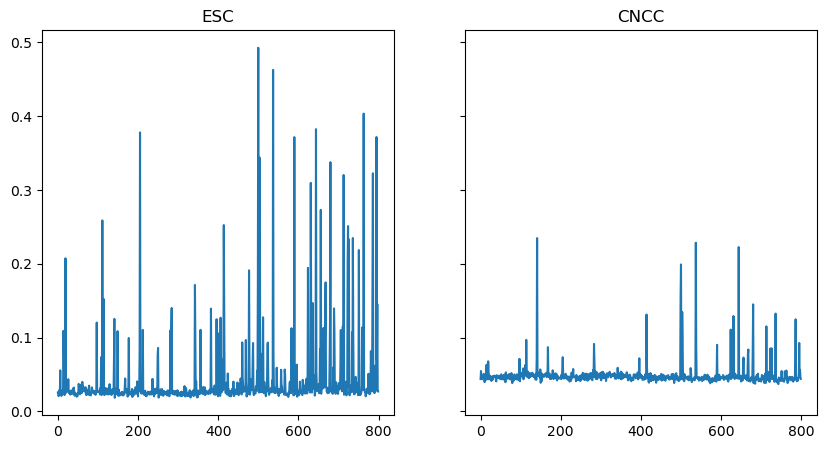

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].plot(summary_list[0])
ax[0].set_title('ESC')
ax[1].plot(summary_list[1])
ax[1].set_title('CNCC')

In [5]:
steep = 5e0
mu = 0.005

ctcf_str_esc = logistic_transformation(summary_list[0], steep=steep, mu=mu) 
ctcf_str_cncc = logistic_transformation(summary_list[1], steep=steep, mu=mu) 

Text(0.5, 1.0, 'CNCC')

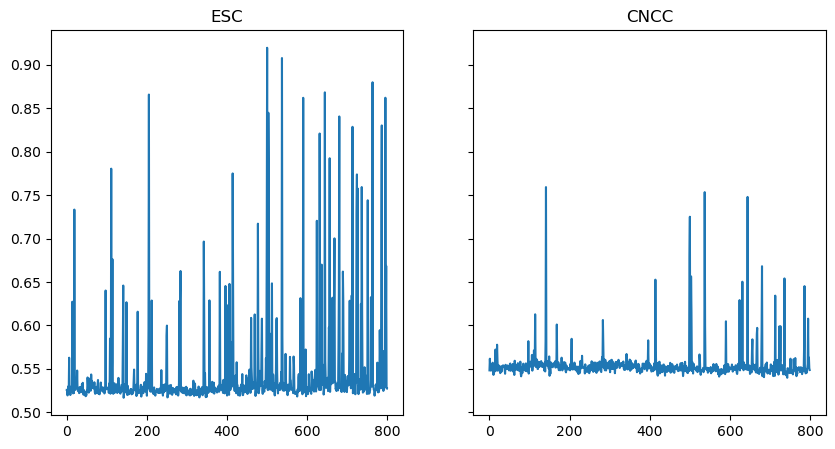

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].plot(ctcf_str_esc)
ax[0].set_title('ESC')
ax[1].plot(ctcf_str_cncc)
ax[1].set_title('CNCC')

In [7]:
# Read ctcf directionality from tsv file
ctcf_dir = pd.read_csv('/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/ctcf_directionality/fimo.tsv', sep='\t')

# Get the CTCF directionality for the region
ctcf_dir_region = ctcf_dir[
    (ctcf_dir['sequence_name'] == chrom) &
    (ctcf_dir['start'] >= start) &
    (ctcf_dir['stop'] <= end)
]

# Bin the CTCF directionality into 80 bins
bins = np.linspace(start, end, num_monomers+1)  # +1 because we have one more bin edge than bins
ctcf_dir_region_bin = pd.cut(ctcf_dir_region['start'], bins, labels=False)

ctcf_dir_region.loc[:, 'bin'] = ctcf_dir_region_bin

/tmp/ipykernel_994713/2849822938.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctcf_dir_region.loc[:, 'bin'] = ctcf_dir_region_bin


In [8]:
ctcf_dir_region.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,bin
8,MA0139.1,CTCF,chr17,71366198.0,71366216.0,-,28.5246,3.420000e-12,0.00153,TGGCCAGCAGGGGGCGCCA,667
308,MA0139.1,CTCF,chr17,71425692.0,71425710.0,+,26.1803,3.070000e-10,0.00564,TGGCCACCAGATGGCGCCC,680
402,MA0139.1,CTCF,chr17,71251992.0,71252010.0,+,25.8197,5.090000e-10,0.00708,TGGCCAGCAGGTGGCAGCA,644
3929,MA0139.1,CTCF,chr17,69080554.0,69080572.0,-,22.1967,2.060000e-08,0.02970,CAACCACCAGGGGGCAGGG,205
4691,MA0139.1,CTCF,chr17,71952911.0,71952929.0,-,21.8197,2.820000e-08,0.03410,AGGCCTGCAGGGGGCACTG,786


(0.0, 300.0)

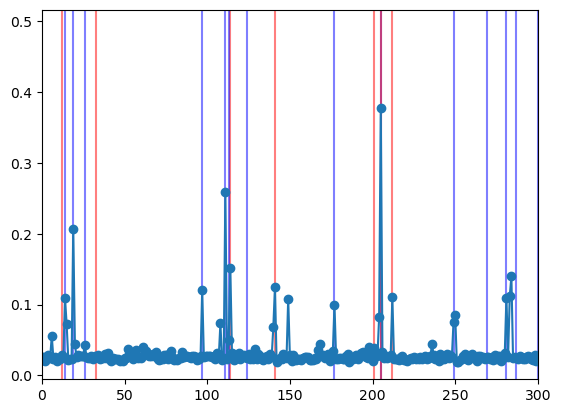

In [9]:
for dir, bin in ctcf_dir_region[['strand', 'bin']].values:
    if dir == '+':
        plt.axvline(bin, color='red', alpha=0.5)
    else:
        plt.axvline(bin, color='blue', alpha=0.5)
plt.plot(summary_list[0], 'o-')
plt.xlim([0, 300])

In [10]:
ctcf_dir_region = ctcf_dir_region.sort_values('bin')

In [11]:
duplicated_bins = ctcf_dir_region[ctcf_dir_region.duplicated(subset='bin')]

In [12]:
duplicated_bins.loc[:, 'strand'] = '0'

In [13]:
duplicated_bins.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,bin
11286,MA0139.1,CTCF,chr17,69081566.0,69081584.0,0,19.6557,1.460000e-07,0.0734,CAACCACAAGGGGGCAGGG,205
51501,MA0139.1,CTCF,chr17,69955206.0,69955224.0,0,15.7213,1.760000e-06,0.1940,TGGTCACCAGATGGCTGCA,382
48176,MA0139.1,CTCF,chr17,69959641.0,69959659.0,0,15.9016,1.590000e-06,0.1870,GTCCCAGCAGAGGGCAGCT,383
13125,MA0139.1,CTCF,chr17,70119901.0,70119919.0,0,19.2623,1.920000e-07,0.0829,CGGCCACCCGGGGGTGCCG,415
5374,MA0139.1,CTCF,chr17,70475475.0,70475493.0,0,21.5410,3.530000e-08,0.0373,CTGCCTCCAGAGGGCGGTC,487


In [14]:
ctcf_dir_region.drop_duplicates(subset='bin', inplace=True, keep=False)

In [15]:
ctcf_dir_region = pd.concat([ctcf_dir_region, duplicated_bins])

In [16]:
ctcf_dir_region['bin']

51497     12
5679      14
70809     19
83141     26
83143     33
        ... 
69499    669
78349    706
49714    736
86022    751
45010    797
Name: bin, Length: 119, dtype: int64

In [17]:
ctcf_dir_region = ctcf_dir_region.sort_values('bin')

In [18]:
# Extract the bin and ctcf directionality 
ctcf_dir_region_bin = ctcf_dir_region[['bin', 'strand']]

ctcf_str_esc_bin = []
ctcf_str_cnc_bin = []
for i in ctcf_dir_region_bin['bin'].values:
    ctcf_str_esc_bin.append(ctcf_str_esc[i])
    ctcf_str_cnc_bin.append(ctcf_str_cncc[i])
    
ctcf_dir_region_bin.loc[:, 'ctcf_str_esc'] = ctcf_str_esc_bin
ctcf_dir_region_bin.loc[:, 'ctcf_str_cnc'] = ctcf_str_cnc_bin

/tmp/ipykernel_994713/3568102017.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctcf_dir_region_bin.loc[:, 'ctcf_str_esc'] = ctcf_str_esc_bin
/tmp/ipykernel_994713/3568102017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctcf_dir_region_bin.loc[:, 'ctcf_str_cnc'] = ctcf_str_cnc_bin


In [19]:
ctcf_dir_region_bin

,bin,strand,ctcf_str_esc,ctcf_str_cnc
51497,12,+,0.530049,0.548586
5679,14,-,0.627304,0.558937
70809,19,-,0.733380,0.577804
83141,26,-,0.548080,0.551640
83143,33,+,0.527195,0.553517
...,...,...,...,...
36045,771,-,0.526364,0.551096
12216,785,-,0.723700,0.575937
4691,786,-,0.830294,0.645264
45856,795,-,0.862160,0.607815


In [20]:
# Add last bin to the end 
ctcf_dir_region_bin.loc[len(ctcf_dir_region_bin), :] = [int(num_monomers), '0', 1, 1]

/tmp/ipykernel_994713/4093704912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctcf_dir_region_bin.loc[len(ctcf_dir_region_bin), :] = [int(num_monomers), '0', 1, 1]


In [21]:
monomers = 5000  # change this to multiple of ctcf sites 
replicates = 1
lef_lifetime = 40  # 40 gives better result than 10
lef_separation = 10
ctcf_sites = None 
ctcf_capture = 1
ctcf_release = 0.003
ctcf_dir = None 
monomer_types = None 
interaction_matrix = None 
trajectory_length = 1000 * 10  # More samples show better results 
density = 0.2
load_prob = 1/monomers 
gpu_id = "0"
repulsion = 6
lef_flag = True 

In [22]:
ctcf_dir_region_bin['bin'].shape

(120,)

In [23]:
ctcf_dir_region_bin['bin'].max()

800.0

120 120 120
239 239 239
358 358 358
477 477 477
596 596 596
715 715 715
834 834 834


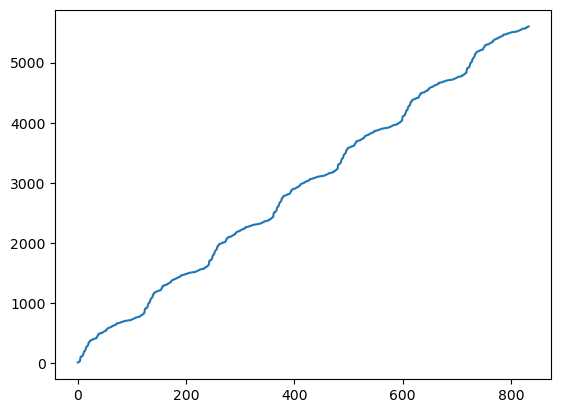

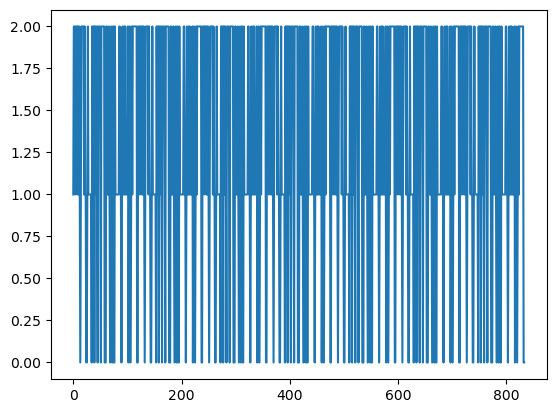

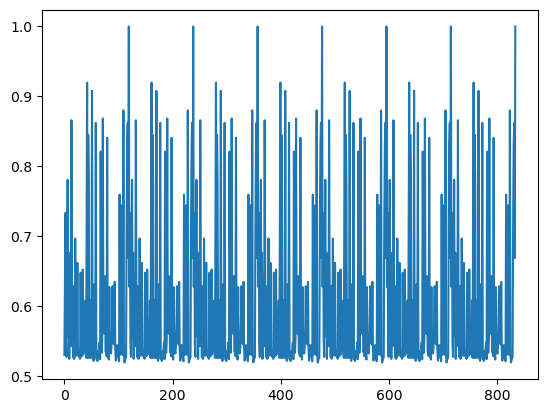

In [24]:
monomers = int(ctcf_dir_region_bin['bin'].max()) * 7

ctcf_sites_one_iter = np.array(ctcf_dir_region_bin['bin'].values)
ctcf_sites = np.append(np.zeros([0]), ctcf_sites_one_iter)  # prevent aliasing
ctcf_capture_one_iter = ctcf_dir_region_bin['ctcf_str_esc'].values
ctcf_capture = np.append(np.zeros([0]), ctcf_capture_one_iter)
ctcf_dir = []

ctcf_dir_one_iter = []
for dir in ctcf_dir_region_bin['strand'].values:
    if dir == '+':
        ctcf_dir_one_iter.append(1)
    elif dir == '-':
        ctcf_dir_one_iter.append(2)
    else:
        ctcf_dir_one_iter.append(0)

ctcf_dir.extend(ctcf_dir_one_iter)
print(len(ctcf_sites), len(ctcf_dir), len(ctcf_capture))

while np.max(ctcf_sites) < monomers: 
    ctcf_sites_next = np.max(ctcf_sites) + ctcf_sites_one_iter
    # The last CTCF sites of the pattern is the first of the next pattern
    ctcf_sites = np.append(ctcf_sites, ctcf_sites_next[1:])
    ctcf_capture = np.append(ctcf_capture, ctcf_capture_one_iter[1:])
    ctcf_dir.extend(ctcf_dir_one_iter[1:])
    print(len(ctcf_sites), len(ctcf_dir), len(ctcf_capture))
    
ctcf_sites = ctcf_sites.astype(int)[:monomers]
ctcf_capture = ctcf_capture[:monomers]
ctcf_dir = ctcf_dir[:monomers]

plt.plot(ctcf_sites)
plt.show()
plt.plot(ctcf_dir)
plt.show()

plt.plot(ctcf_capture)

In [25]:
ctcf_release = np.ones_like(ctcf_sites) * ctcf_release
load_prob = np.ones(monomers) * load_prob

In [26]:
monomer_types = np.zeros(monomers, dtype=int)
interaction_matrix = np.array([[0, 0], [0, 0]])

In [27]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241024_Sox9_Interactive_2/'

In [28]:
# Change here
params = {
    'monomers': monomers,
    'replicates': replicates,
    'lef_lifetime': lef_lifetime,
    'lef_separation': lef_separation,
    'ctcf_capture': ctcf_capture,
    'ctcf_release': ctcf_release,
    'save_folder': save_folder,
    'ctcf_dir': ctcf_dir,
    'ctcf_sites': ctcf_sites,
    'monomer_types': monomer_types,
    'interaction_matrix': interaction_matrix,
    'trajectory_length': trajectory_length,
    'density': density,
    'load_prob': load_prob,
    'gpu_id': gpu_id,
    'repulsion': repulsion,
    'lef_flag': True
}

In [29]:

# general parameters 
trajectoryLength = params['trajectory_length'] # time duration of simulation 
density = params['density'] #  0.2  # fraction of the volume of the sphere which is occupied by the polymer (or effective excluded volume, if using periodic boundary conditions)
  
   
#  ==========Extrusion sim parameters====================
# there is probably a more elegant way to read in text values than ast.literal_eval, but this works.  
GPU_ID = params['gpu_id'] # this should be a string -- which GPU to run on, eg "0", or "1" 
repulsionEnergy = params['repulsion'] # this is just a number
N1 = params['monomers'] # Number of monomers in the polymer/chromosome
M = params['replicates']  # Number of chromosomes in the simulation
num_chains = M  # same as above, multiple variable names were introduced.
N = N1 * M # total number of monomers in the full simulation 
LIFETIME = params['lef_lifetime'] #  extruder lifetime
SEPARATION = params['lef_separation'] # separation between extruders in monomer units (extruder density) 
ctcfSites = params['ctcf_sites'] # CTCF site locations, in monomer units
ctcfDir = params['ctcf_dir']  # CTCF site direction 
ctcfCapture = params['ctcf_capture'] # 0.9 80% capture probability per block, if capture < than this, capture  
ctcfRelease = params['ctcf_release'] # 0.003 % release probability per block, if capture < than this, release
interactionMatrix = params['interaction_matrix']  # interaction strength between different compartments 
saveFolder = params['save_folder']  # place to save the data
oneChainMonomerTypes =  params['monomer_types'] # compartment labels
lefFlag = params['lef_flag']
if len(oneChainMonomerTypes) != N1:
    oneChainMonomerTypes = np.zeros(N1).astype(int)
    
# Allow biased cohesin loading probabilities (e.g. as a function of chromatin state), if desired
loadProb = params['load_prob'] # discrete probability distribution that cohesin loads at site N
loadProb = numpy.matlib.repmat(loadProb,1,M)
loadProb = loadProb/np.sum(loadProb) 

if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)

lefPosFile = saveFolder + "LEFPos.h5"
if lefFlag:
    LEFNum = max(0,math.floor(N // SEPARATION )-1)
else:
    LEFNum = 0

# Optionally, tether the chromosome ends at random positions on the nulcear lamina
#   to use this, line 245 should be replaced with the commented line below it. 
#   select M random points on the edge of sphere
r = 1.05*(3 * N/ (4 * np.pi * density)) ** (1 / 3.0)
theta =np.random.rand(num_chains,1)*np.pi
psi = np.random.rand(num_chains,1)*2*np.pi
x= r*np.cos(psi)*np.sin(theta)
y= r*np.sin(psi)*np.sin(theta)
z= r*np.cos(theta)
end_tethers = np.concatenate((x,y,z),axis=1).tolist() 


# less common parameters
attraction_radius = 1.5
MDstepsPerCohesinStep = 800
smcBondWiggleDist = 0.2
smcBondDist = 0.5
saveEveryBlocks = 100   #
restartSimulationEveryBlocks = 100

# check that these loaded alright
print(f'LEF count: {LEFNum}')
print('interaction matrix:')
print(interactionMatrix)
print('monomer types:')
print(oneChainMonomerTypes)
print(saveFolder)
print('Starting simulation')


LEF count: 559
interaction matrix:
[[0 0]
 [0 0]]
monomer types:
[0 0 0 ... 0 0 0]
/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241024_Sox9_Interactive_2/
Starting simulation


In [30]:


#==================================#
# Run 
#=================================#

#=========== 1D LE Simulation first ============#
import extrusion1Dv2 as ex1D # 1D classes 
ctcfLeftRelease = {}
ctcfRightRelease = {}
ctcfLeftCapture = {}
ctcfRightCapture = {}

# should modify this to allow directionality
for i in range(M): # loop over chains (this variable needs a better name Max)
    for t in range(len(ctcfSites)):
        pos = i * N1 + ctcfSites[t] 
        if ctcfDir[t] == 0:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 1: # stop Cohesin moving toward the right  
            ctcfLeftCapture[pos] = 0  
            ctcfLeftRelease[pos] = 1  
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 2:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = 0
            ctcfRightRelease[pos] = 1
       
args = {}
args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = LIFETIME
args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled 

occupied = np.zeros(N)
occupied[0] = 1  # (I think this is just prevent the cohesin loading at the end by making it already occupied)
occupied[-1] = 1 # [-1] is "python" for end
cohesins = []

print('starting simulation with N LEFs=')
print(LEFNum)
for i in tqdm(range(LEFNum)):
    ex1D.loadOneFromDist(cohesins,occupied, args,loadProb) # load the cohesins 
    
# if lefPosFile exists, delete it
if os.path.exists(lefPosFile):
    os.remove(lefPosFile)


with h5py.File(lefPosFile, mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")
    steps = 100    # saving in 100 chunks because the whole trajectory may be large 
    bins = np.linspace(0, trajectoryLength, steps, dtype=int) # chunks boundaries 
    print(len(bins))
    for st,end in tqdm(zip(bins[:-1], bins[1:])):
        cur = []
        for i in range(st, end):
            ex1D.translocate(cohesins, occupied, args,loadProb)  # actual step of LEF dynamics 
            positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
            cur.append(positions)  # appending current positions to an array 
        cur = np.array(cur)  # when we finished a block of positions, save it to HDF5 
        dset[st:end] = cur
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum
    


starting simulation with N LEFs=
559


  0%|          | 0/559 [00:00<?, ?it/s]

100


0it [00:00, ?it/s]

In [31]:
#=========== Load LEF simulation ===========#
trajectory_file = h5py.File(lefPosFile, mode='r')
LEFNum = trajectory_file.attrs["LEFNum"]  # number of LEFs
LEFpositions = trajectory_file["positions"]  # array of LEF positions  
steps = MDstepsPerCohesinStep # MD steps per step of cohesin  (set to ~800 in real sims)
Nframes = LEFpositions.shape[0] # length of the saved trajectory (>25000 in real sims)
print(f'Length of the saved trajectory: {Nframes}')
block = 0  # starting block 

# test some properties 
# assertions for easy managing code below 
assert (Nframes % restartSimulationEveryBlocks) == 0 
assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0

savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
simInitsTotal  = (Nframes) // restartSimulationEveryBlocks
# concatinate monomers if needed
if len(oneChainMonomerTypes) != N:
    monomerTypes = np.tile(oneChainMonomerTypes, num_chains)
else:
    monomerTypes = oneChainMonomerTypes
    
N_chain = len(oneChainMonomerTypes)  
N = len(monomerTypes)
print(f'N_chain: {N_chain}')  # ~8000 in a real sim
print(f'N: {N}')   # ~40000 in a real sim
N_traj = trajectory_file.attrs["N"]
print(f'N_traj: {N_traj}')
assert N == trajectory_file.attrs["N"]
print(f'Nframes: {Nframes}')
print(f'simInitsTotal: {simInitsTotal}')


Length of the saved trajectory: 10000
N_chain: 5600
N: 5600
N_traj: 5600
Nframes: 10000
simInitsTotal: 100


In [32]:
LEFpositions.shape

(10000, 559, 2)

In [33]:
LEFpositions[0, 1, :], LEFpositions[1, 1, :], LEFpositions[2, 1, :], LEFpositions[3, 1, :]

(array([746, 749], dtype=int32),
 array([745, 750], dtype=int32),
 array([744, 751], dtype=int32),
 array([743, 751], dtype=int32))

In [34]:

#==============================================================#
#      RUN 3D simulation using 1D LEF constraints              #
#==============================================================#
milker = bondUpdater(LEFpositions)
data = grow_cubic(N,int((N/(density*1.2))**0.333))  # starting conformation
reporter = HDF5Reporter(folder=saveFolder, max_data_length=50, overwrite=True)
chains = [(N_chain*(k),N_chain*(k+1),0) for k in range(num_chains)]
positions_all_iterations = []

for iteration in tqdm(range(simInitsTotal)):
    position_curr_iteration = []
    a = Simulation(N=N, 
                   error_tol=0.01, 
                   collision_rate=0.01, 
                   integrator ="variableLangevin", 
                   GPU = "0",
                   platform="CUDA",
                   PBCbox=False, 
                   reporters=[reporter],
                   precision="mixed")  
    a.set_data(data)  # Start from previous positions
    position_curr_iteration.append(a.get_data())
    a.add_force(
        polychrom.forcekits.polymer_chains(
            a,
            chains=chains,
            nonbonded_force_func=polychrom.forces.heteropolymer_SSW,
            nonbonded_force_kwargs={
                'repulsionEnergy': repulsionEnergy,  # base repulsion energy for all monomers (function default is 3.0)
                'attractionEnergy': 0,  # base attraction energy for all monomers (function default is 3.0)
                'attractionRadius': attraction_radius,
                'interactionMatrix': interactionMatrix,
                'monomerTypes': monomerTypes,
                'extraHardParticlesIdxs': []
            },
            bond_force_kwargs={
                'bondLength': 1,
                'bondWiggleDistance': 0.05
            },
            angle_force_kwargs={
                'k': 0.5 
            }
        )
    )
    a.add_force(polychrom.forces.spherical_confinement(a,density=density))
    # a.add_force(polychrom.forces.tether_particles(a,[0,N-1],positions=end_tethers,k=30))  # tether ends of polymer)
    
    # ------------ initializing milker; adding bonds ---------
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    bondDist = smcBondDist * a.length_scale
    activeParams = {"length":bondDist,"k":kbond}
    inactiveParams = {"length":bondDist, "k":0}
    
    milker.setParams(activeParams, inactiveParams)
    # this step actually puts all bonds in and sets first bonds to be what they should be
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                blocks=restartSimulationEveryBlocks)

    if iteration == 0:
        a.local_energy_minimization() 
        position_curr_iteration.append(a.get_data())
    else:
        a._apply_forces()
        position_curr_iteration.append(a.get_data())
    
    for i in range(restartSimulationEveryBlocks):        
        if i % saveEveryBlocks == (saveEveryBlocks - 1):  
            a.do_block(steps=steps)
            position_curr_iteration.append(a.get_data())
        else:
            a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
            position_curr_iteration.append(a.get_data())
        if i < restartSimulationEveryBlocks - 1: 
            curBonds, pastBonds = milker.step(a.context)  # this updates bonds.
    
    # Change this line - move it inside the for loop to get a movie of the simulation
    data = a.get_data()  # save data and step, and delete the simulation
    
    del a
    
    reporter.blocks_only = False  # Write output hdf5-files only for blocks
    
    time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
    positions_all_iterations.append(position_curr_iteration)

reporter.dump_data()

  0%|          | 0/100 [00:00<?, ?it/s]

Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 26.606677
INFO:root:before minimization eK=1.5071984557416447, eP=26.60667652790322, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.960283
INFO:root:after minimization eK=1.5071984557416447, eP=0.8162819630186083, time=0.0 ps
INFO:root:block    0 pos[1]=[2.5 11.8 3.3] dr=14.58 t=9131.0ps kin=1.75 pot=1.75 Rg=13.853 SPS=9290 dt=114.6fs dx=33.89pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.376999
INFO:root:block    0 pos[1]=[8.1 5.0 15.7] dr=10.09 t=9180.1ps kin=1.78 pot=1.75 Rg=13.925 SPS=9237 dt=113.4fs dx=33.76pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.538729
INFO:root:block    0 pos[1]=[-4.1 3.1 14.5] dr=9.79 t=9046.8ps kin=1.75 pot=1.76 Rg=13.771 SPS=9286 dt=115.1fs dx=33.97pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.371471
INFO:root:block    0 pos[1]=[-6.3 -3.2 13.3] dr=10.28 t=9115.7ps kin=1.83 pot=1.77 Rg=13.914 SPS=9234 dt=113.9fs dx=34.37pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.486695
INFO:root:block    0 pos[1]=[-7.2 0.2 11.8] dr=8.80 t=9127.2ps kin=1.75 pot=1.79 Rg=14.007 SPS=9233 dt=114.3fs dx=33.77pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.523940
INFO:root:block    0 pos[1]=[4.9 -8.0 15.4] dr=11.09 t=9170.9ps kin=1.76 pot=1.77 Rg=13.819 SPS=9261 dt=113.6fs dx=33.60pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.597123
INFO:root:block    0 pos[1]=[-3.3 10.9 12.4] dr=10.25 t=9098.7ps kin=1.77 pot=1.77 Rg=13.798 SPS=9212 dt=114.4fs dx=33.97pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.459643
INFO:root:block    0 pos[1]=[1.3 8.2 12.8] dr=9.97 t=9219.7ps kin=1.79 pot=1.77 Rg=13.758 SPS=9242 dt=114.5fs dx=34.22pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.591221
INFO:root:block    0 pos[1]=[-5.7 -15.7 9.4] dr=11.08 t=9137.4ps kin=1.79 pot=1.78 Rg=13.887 SPS=9226 dt=114.3fs dx=34.16pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.622451
INFO:root:block    0 pos[1]=[-11.7 -3.6 10.9] dr=9.52 t=9126.3ps kin=1.78 pot=1.77 Rg=13.930 SPS=9183 dt=115.3fs dx=34.33pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.531369
INFO:root:block    0 pos[1]=[-13.0 4.6 9.6] dr=10.35 t=9135.2ps kin=1.77 pot=1.76 Rg=13.801 SPS=9303 dt=114.1fs dx=33.89pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.455288
INFO:root:block    0 pos[1]=[-8.1 -4.8 14.6] dr=10.19 t=9154.3ps kin=1.74 pot=1.75 Rg=13.910 SPS=9246 dt=114.3fs dx=33.65pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.384733
INFO:root:block    0 pos[1]=[-7.3 6.3 14.5] dr=10.08 t=9118.6ps kin=1.80 pot=1.76 Rg=13.708 SPS=9227 dt=113.5fs dx=34.02pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.383176
INFO:root:block    0 pos[1]=[-13.3 0.1 8.0] dr=12.91 t=9190.5ps kin=1.79 pot=1.76 Rg=13.864 SPS=9245 dt=114.6fs dx=34.24pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.461177
INFO:root:block    0 pos[1]=[1.2 -6.8 6.8] dr=11.29 t=9161.1ps kin=1.76 pot=1.76 Rg=13.838 SPS=9218 dt=114.3fs dx=33.91pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.514282
INFO:root:block    0 pos[1]=[-0.5 -2.2 4.1] dr=10.94 t=9094.4ps kin=1.79 pot=1.73 Rg=13.941 SPS=9244 dt=114.1fs dx=34.09pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.392423
INFO:root:block    0 pos[1]=[5.4 -11.5 11.4] dr=10.36 t=9058.2ps kin=1.79 pot=1.76 Rg=13.895 SPS=9193 dt=113.2fs dx=33.79pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.514159
INFO:root:block    0 pos[1]=[5.2 -2.2 -3.1] dr=9.69 t=9034.8ps kin=1.71 pot=1.80 Rg=13.917 SPS=9277 dt=112.9fs dx=33.02pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.527183
INFO:root:block    0 pos[1]=[-3.2 -11.6 9.7] dr=10.67 t=9147.4ps kin=1.80 pot=1.77 Rg=13.892 SPS=9236 dt=114.2fs dx=34.19pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.582891
INFO:root:block    0 pos[1]=[-3.6 -11.6 -2.3] dr=11.92 t=9047.0ps kin=1.77 pot=1.76 Rg=14.123 SPS=9241 dt=113.1fs dx=33.60pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.467047
INFO:root:block    0 pos[1]=[0.6 -11.2 13.0] dr=10.95 t=9095.0ps kin=1.72 pot=1.75 Rg=13.973 SPS=9241 dt=113.4fs dx=33.21pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.431884
INFO:root:block    0 pos[1]=[-1.5 -8.2 12.9] dr=10.80 t=9174.9ps kin=1.83 pot=1.77 Rg=13.923 SPS=9118 dt=114.7fs dx=34.63pm 
INFO:root:adding force harmonic_bonds 0


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.502222
INFO:root:block    0 pos[1]=[-0.8 -2.7 12.1] dr=9.38 t=9157.1ps kin=1.76 pot=1.78 Rg=13.924 SPS=9126 dt=114.5fs dx=33.95pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.586036
INFO:root:block    0 pos[1]=[-5.4 -9.3 13.6] dr=9.24 t=9094.0ps kin=1.74 pot=1.76 Rg=14.033 SPS=9266 dt=113.6fs dx=33.48pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.523954
INFO:root:block    0 pos[1]=[-12.7 -0.0 1.2] dr=10.32 t=9161.7ps kin=1.74 pot=1.77 Rg=13.882 SPS=9245 dt=114.3fs dx=33.66pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.457616
INFO:root:block    0 pos[1]=[-13.8 -8.4 8.1] dr=9.35 t=9020.9ps kin=1.78 pot=1.77 Rg=13.776 SPS=9212 dt=112.8fs dx=33.61pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.598489
INFO:root:block    0 pos[1]=[0.8 -15.4 6.1] dr=8.85 t=9142.8ps kin=1.74 pot=1.75 Rg=13.915 SPS=9259 dt=114.2fs dx=33.63pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.382555
INFO:root:block    0 pos[1]=[-3.2 -11.5 1.4] dr=11.70 t=9177.2ps kin=1.79 pot=1.75 Rg=13.892 SPS=9217 dt=114.2fs dx=34.10pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.425066
INFO:root:block    0 pos[1]=[-4.8 -16.6 -5.7] dr=9.50 t=9201.3ps kin=1.75 pot=1.74 Rg=13.930 SPS=9216 dt=114.8fs dx=33.92pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.380309
INFO:root:block    0 pos[1]=[11.7 -7.0 6.5] dr=11.17 t=9140.3ps kin=1.80 pot=1.82 Rg=14.092 SPS=9242 dt=113.9fs dx=34.12pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.505594
INFO:root:block    0 pos[1]=[2.3 -10.9 -12.9] dr=9.61 t=9179.7ps kin=1.77 pot=1.75 Rg=13.859 SPS=9200 dt=115.1fs dx=34.20pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.498601
INFO:root:block    0 pos[1]=[3.4 -3.0 -6.5] dr=10.04 t=9166.1ps kin=1.79 pot=1.78 Rg=13.982 SPS=9239 dt=114.5fs dx=34.17pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.463628
INFO:root:block    0 pos[1]=[4.4 -12.1 -12.1] dr=10.07 t=9193.1ps kin=1.74 pot=1.73 Rg=13.849 SPS=9253 dt=114.6fs dx=33.79pm 
INFO:root:adding force harmonic_bonds 0


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.330662
INFO:root:block    0 pos[1]=[4.7 -9.6 -9.8] dr=11.35 t=9152.7ps kin=1.82 pot=1.79 Rg=13.943 SPS=9263 dt=113.9fs dx=34.34pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.572606
INFO:root:block    0 pos[1]=[2.7 -12.7 -6.7] dr=11.05 t=9034.9ps kin=1.72 pot=1.75 Rg=13.837 SPS=9263 dt=112.9fs dx=33.11pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.522309
INFO:root:block    0 pos[1]=[-1.3 0.2 0.9] dr=9.06 t=9213.5ps kin=1.74 pot=1.75 Rg=13.952 SPS=9167 dt=115.0fs dx=33.92pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.414890
INFO:root:block    0 pos[1]=[-3.8 3.9 8.4] dr=9.38 t=9055.2ps kin=1.81 pot=1.79 Rg=13.822 SPS=9207 dt=113.2fs dx=34.00pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.710246
INFO:root:block    0 pos[1]=[6.1 1.2 7.4] dr=10.32 t=9178.1ps kin=1.78 pot=1.76 Rg=13.925 SPS=9270 dt=114.6fs dx=34.19pm 
INFO:root:adding force harmonic_bonds 0


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.527200
INFO:root:block    0 pos[1]=[-6.9 -5.6 -0.9] dr=9.12 t=9114.5ps kin=1.74 pot=1.74 Rg=13.818 SPS=9230 dt=113.7fs dx=33.53pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.324627
INFO:root:block    0 pos[1]=[2.8 -2.7 -1.7] dr=10.07 t=9146.3ps kin=1.75 pot=1.75 Rg=13.983 SPS=9222 dt=114.3fs dx=33.83pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.491963
INFO:root:block    0 pos[1]=[-5.5 12.4 7.5] dr=9.95 t=9173.0ps kin=1.75 pot=1.76 Rg=13.756 SPS=9276 dt=114.3fs dx=33.76pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.433017
INFO:root:block    0 pos[1]=[-11.3 9.1 -5.0] dr=9.76 t=9049.3ps kin=1.74 pot=1.74 Rg=14.087 SPS=9230 dt=115.2fs dx=33.97pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.280101
INFO:root:block    0 pos[1]=[-10.9 4.0 -9.9] dr=9.10 t=9104.2ps kin=1.75 pot=1.75 Rg=13.968 SPS=9331 dt=113.8fs dx=33.59pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.488137
INFO:root:block    0 pos[1]=[-11.9 10.5 -6.8] dr=9.73 t=9170.1ps kin=1.70 pot=1.74 Rg=14.035 SPS=9323 dt=114.1fs dx=33.26pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.330271
INFO:root:block    0 pos[1]=[1.2 9.0 -11.9] dr=11.95 t=9184.0ps kin=1.79 pot=1.79 Rg=13.980 SPS=9244 dt=113.8fs dx=34.05pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.562788
INFO:root:block    0 pos[1]=[5.7 8.6 -8.0] dr=10.39 t=9127.3ps kin=1.77 pot=1.78 Rg=13.747 SPS=9348 dt=114.1fs dx=33.89pm 
INFO:root:adding force harmonic_bonds 0


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.405531
INFO:root:block    0 pos[1]=[4.9 10.9 -2.4] dr=10.22 t=9136.4ps kin=1.74 pot=1.76 Rg=13.917 SPS=9291 dt=113.9fs dx=33.58pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.550159
INFO:root:block    0 pos[1]=[-8.7 0.9 -2.1] dr=11.42 t=9160.6ps kin=1.81 pot=1.76 Rg=13.904 SPS=9216 dt=114.2fs dx=34.26pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.481253
INFO:root:block    0 pos[1]=[-3.1 10.0 5.3] dr=12.71 t=9011.4ps kin=1.79 pot=1.74 Rg=13.987 SPS=9300 dt=112.6fs dx=33.71pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.627441
INFO:root:block    0 pos[1]=[-2.4 9.5 -5.1] dr=10.01 t=9105.7ps kin=1.75 pot=1.76 Rg=13.952 SPS=9193 dt=113.8fs dx=33.65pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.412413
INFO:root:block    0 pos[1]=[4.0 14.1 -3.3] dr=10.23 t=9177.8ps kin=1.77 pot=1.75 Rg=13.979 SPS=9202 dt=114.4fs dx=33.95pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.574915
INFO:root:block    0 pos[1]=[-7.3 15.4 -3.7] dr=10.98 t=9159.4ps kin=1.76 pot=1.74 Rg=13.771 SPS=9153 dt=114.2fs dx=33.88pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.363212
INFO:root:block    0 pos[1]=[-16.3 -0.1 2.3] dr=11.03 t=9030.1ps kin=1.73 pot=1.77 Rg=13.764 SPS=9256 dt=112.9fs dx=33.21pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.454464
INFO:root:block    0 pos[1]=[-7.9 10.1 10.6] dr=10.13 t=9130.0ps kin=1.70 pot=1.76 Rg=13.891 SPS=9364 dt=114.7fs dx=33.36pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.426940
INFO:root:block    0 pos[1]=[6.8 0.2 8.2] dr=10.22 t=9149.3ps kin=1.83 pot=1.80 Rg=13.957 SPS=9281 dt=114.0fs dx=34.44pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.593557
INFO:root:block    0 pos[1]=[-1.2 -2.8 10.6] dr=10.12 t=9148.3ps kin=1.82 pot=1.76 Rg=13.971 SPS=9204 dt=114.1fs dx=34.43pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.473496
INFO:root:block    0 pos[1]=[4.5 -4.3 16.5] dr=10.20 t=9134.8ps kin=1.85 pot=1.76 Rg=13.933 SPS=9235 dt=113.6fs dx=34.52pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.495562
INFO:root:block    0 pos[1]=[3.6 0.3 18.0] dr=10.43 t=9155.3ps kin=1.79 pot=1.76 Rg=13.860 SPS=9236 dt=114.4fs dx=34.14pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.419800
INFO:root:block    0 pos[1]=[1.2 6.2 14.9] dr=9.69 t=9159.4ps kin=1.78 pot=1.80 Rg=13.891 SPS=9222 dt=114.4fs dx=34.08pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.524396
INFO:root:block    0 pos[1]=[2.0 -4.2 10.1] dr=10.26 t=9157.8ps kin=1.74 pot=1.75 Rg=13.943 SPS=9216 dt=114.5fs dx=33.72pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.678769
INFO:root:block    0 pos[1]=[-5.6 -0.4 8.8] dr=11.99 t=9167.1ps kin=1.71 pot=1.72 Rg=13.939 SPS=9215 dt=114.8fs dx=33.55pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.482403
INFO:root:block    0 pos[1]=[-9.7 14.3 1.6] dr=9.09 t=9167.1ps kin=1.83 pot=1.79 Rg=13.820 SPS=9204 dt=114.5fs dx=34.60pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.520933
INFO:root:block    0 pos[1]=[-7.8 10.4 7.5] dr=9.34 t=9148.9ps kin=1.75 pot=1.77 Rg=13.791 SPS=9251 dt=114.2fs dx=33.70pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.457880
INFO:root:block    0 pos[1]=[-0.9 8.9 5.4] dr=9.92 t=9090.9ps kin=1.74 pot=1.75 Rg=14.067 SPS=9296 dt=113.5fs dx=33.49pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.587845
INFO:root:block    0 pos[1]=[9.4 -6.7 12.7] dr=10.33 t=9118.0ps kin=1.72 pot=1.77 Rg=13.943 SPS=9230 dt=114.0fs dx=33.36pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.424975
INFO:root:block    0 pos[1]=[-1.1 -9.0 5.2] dr=9.59 t=9066.0ps kin=1.74 pot=1.77 Rg=13.868 SPS=9177 dt=114.4fs dx=33.71pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.452504
INFO:root:block    0 pos[1]=[12.1 -1.8 12.8] dr=9.67 t=9009.3ps kin=1.74 pot=1.78 Rg=13.785 SPS=9222 dt=112.6fs dx=33.17pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.535438
INFO:root:block    0 pos[1]=[4.0 9.0 9.4] dr=11.46 t=9102.5ps kin=1.73 pot=1.74 Rg=13.769 SPS=9212 dt=114.4fs dx=33.64pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.304332
INFO:root:block    0 pos[1]=[3.2 6.1 3.3] dr=9.93 t=9030.9ps kin=1.73 pot=1.74 Rg=13.983 SPS=9200 dt=112.9fs dx=33.20pm 
INFO:root:adding force harmonic_bonds 0


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.483956
INFO:root:block    0 pos[1]=[-1.9 0.3 16.6] dr=9.81 t=9063.6ps kin=1.70 pot=1.75 Rg=13.928 SPS=9218 dt=113.3fs dx=33.02pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.361594
INFO:root:block    0 pos[1]=[-0.3 -2.2 0.1] dr=10.34 t=9174.3ps kin=1.70 pot=1.75 Rg=13.827 SPS=9219 dt=114.8fs dx=33.40pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.329278
INFO:root:block    0 pos[1]=[7.4 4.8 -1.1] dr=10.30 t=9174.9ps kin=1.76 pot=1.77 Rg=14.021 SPS=9149 dt=114.2fs dx=33.81pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.323751
INFO:root:block    0 pos[1]=[1.1 2.4 -0.5] dr=11.65 t=9182.3ps kin=1.73 pot=1.76 Rg=13.838 SPS=9249 dt=114.0fs dx=33.46pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.425936
INFO:root:block    0 pos[1]=[-13.3 -0.7 6.1] dr=10.11 t=9144.4ps kin=1.74 pot=1.76 Rg=14.072 SPS=9231 dt=114.6fs dx=33.80pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.452182
INFO:root:block    0 pos[1]=[-9.8 10.8 11.1] dr=10.60 t=9020.9ps kin=1.81 pot=1.77 Rg=13.901 SPS=9220 dt=112.8fs dx=33.91pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.445072
INFO:root:block    0 pos[1]=[-2.6 1.2 6.2] dr=9.64 t=9144.0ps kin=1.73 pot=1.78 Rg=13.874 SPS=9215 dt=114.6fs dx=33.63pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.555037
INFO:root:block    0 pos[1]=[0.1 3.4 2.9] dr=9.86 t=9193.8ps kin=1.74 pot=1.75 Rg=13.734 SPS=9289 dt=114.6fs dx=33.76pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.443509
INFO:root:block    0 pos[1]=[4.8 2.8 -8.2] dr=9.30 t=9180.1ps kin=1.74 pot=1.77 Rg=13.933 SPS=9247 dt=114.7fs dx=33.83pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.408226
INFO:root:block    0 pos[1]=[-11.2 4.3 1.9] dr=10.96 t=9107.5ps kin=1.79 pot=1.80 Rg=13.946 SPS=9269 dt=114.3fs dx=34.18pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.576270
INFO:root:block    0 pos[1]=[-4.2 -4.6 -1.9] dr=12.14 t=9127.9ps kin=1.76 pot=1.78 Rg=14.061 SPS=9208 dt=114.0fs dx=33.82pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.590373
INFO:root:block    0 pos[1]=[-10.9 11.4 4.1] dr=10.16 t=9191.5ps kin=1.75 pot=1.75 Rg=13.795 SPS=9175 dt=114.0fs dx=33.67pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.401386
INFO:root:block    0 pos[1]=[-1.9 13.2 1.0] dr=10.41 t=9169.4ps kin=1.76 pot=1.78 Rg=13.746 SPS=9227 dt=114.5fs dx=33.94pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.455555
INFO:root:block    0 pos[1]=[-8.7 11.4 3.8] dr=9.58 t=9159.1ps kin=1.77 pot=1.79 Rg=13.918 SPS=9309 dt=114.2fs dx=33.89pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.676255
INFO:root:block    0 pos[1]=[-3.1 13.7 4.0] dr=9.03 t=9171.7ps kin=1.79 pot=1.79 Rg=13.949 SPS=9284 dt=114.4fs dx=34.17pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.616243
INFO:root:block    0 pos[1]=[-0.4 5.2 10.8] dr=9.46 t=9173.9ps kin=1.76 pot=1.75 Rg=13.932 SPS=9223 dt=114.6fs dx=33.92pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.408632
INFO:root:block    0 pos[1]=[3.5 8.6 11.2] dr=11.07 t=9030.4ps kin=1.73 pot=1.74 Rg=13.950 SPS=9253 dt=112.9fs dx=33.21pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.255145
INFO:root:block    0 pos[1]=[1.3 14.1 -1.6] dr=10.21 t=9207.7ps kin=1.78 pot=1.79 Rg=13.909 SPS=9225 dt=114.7fs dx=34.18pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.530936
INFO:root:block    0 pos[1]=[3.2 15.8 -2.0] dr=10.86 t=9144.3ps kin=1.78 pot=1.78 Rg=13.850 SPS=9225 dt=114.2fs dx=34.01pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.680758
INFO:root:block    0 pos[1]=[8.4 11.4 1.4] dr=10.63 t=9174.1ps kin=1.78 pot=1.78 Rg=13.991 SPS=9212 dt=114.3fs dx=34.05pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.621839
INFO:root:block    0 pos[1]=[0.2 4.4 -4.6] dr=9.75 t=9157.0ps kin=1.74 pot=1.75 Rg=13.964 SPS=9258 dt=114.3fs dx=33.64pm 
INFO:root:adding force harmonic_bonds 0


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.371516
INFO:root:block    0 pos[1]=[11.4 9.4 -8.4] dr=9.57 t=9043.6ps kin=1.81 pot=1.78 Rg=13.969 SPS=9224 dt=113.0fs dx=33.95pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.506679
INFO:root:block    0 pos[1]=[2.1 -6.5 -14.5] dr=11.37 t=9206.0ps kin=1.71 pot=1.76 Rg=13.903 SPS=9213 dt=114.8fs dx=33.51pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.360823
INFO:root:block    0 pos[1]=[1.0 2.1 -14.7] dr=9.08 t=9167.1ps kin=1.79 pot=1.77 Rg=13.925 SPS=9251 dt=114.0fs dx=34.07pm 
INFO:root:adding force harmonic_bonds 0


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.490319
INFO:root:block    0 pos[1]=[0.6 6.8 -4.1] dr=10.89 t=9142.3ps kin=1.81 pot=1.77 Rg=13.897 SPS=9354 dt=114.3fs dx=34.31pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.420417
INFO:root:block    0 pos[1]=[14.2 7.8 -6.1] dr=11.43 t=9174.9ps kin=1.75 pot=1.79 Rg=14.019 SPS=9276 dt=114.5fs dx=33.89pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.661492
INFO:root:block    0 pos[1]=[-9.9 6.7 -10.7] dr=10.76 t=9173.5ps kin=1.78 pot=1.75 Rg=13.931 SPS=9390 dt=114.8fs dx=34.16pm 
INFO:root:adding force harmonic_bonds 0


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.467873
INFO:root:block    0 pos[1]=[-0.1 15.6 -11.0] dr=9.26 t=9131.5ps kin=1.77 pot=1.76 Rg=13.851 SPS=9327 dt=114.5fs dx=34.03pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.496887
INFO:root:block    0 pos[1]=[2.7 8.5 -5.3] dr=11.32 t=9128.5ps kin=1.74 pot=1.76 Rg=14.132 SPS=9310 dt=114.2fs dx=33.69pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.607583
INFO:root:block    0 pos[1]=[-2.6 12.8 8.7] dr=11.75 t=9061.5ps kin=1.78 pot=1.76 Rg=13.854 SPS=9284 dt=113.6fs dx=33.82pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5599


INFO:root:Particles loaded. Potential energy is 2.669274
INFO:root:block    0 pos[1]=[6.6 6.1 0.2] dr=10.81 t=9132.3ps kin=1.73 pot=1.75 Rg=13.899 SPS=9262 dt=113.9fs dx=33.44pm 


In [35]:
positions_all_iterations = np.array(positions_all_iterations)

In [36]:
def visualize_polymer(polymer_chain: ArrayLike, save_path: str = '') -> None:
    """Plot a polymer chain in 3D space and optionally save the figure 
    
    Monomers are colored by the distance from one end of the polymer. 
    
    Parameters
    ----------
    polymer_chain : numpy.ndarray
                    an `num_monomers-by-3` ArrayLike of monomer coordinates 
    save_path : str, optional
                path to save the figure
                
    """
    # Extract each coordinate of this polymer chain 
    x = polymer_chain[:, 0]
    y = polymer_chain[:, 1]
    z = polymer_chain[:, 2]
  
    # Normalize the monomer number 
    num_monomers = polymer_chain.shape[0] 
    norm_monomer_number = np.arange(0, num_monomers) / num_monomers
    monomer_colors = cm.rainbow(norm_monomer_number)

    x_fine = x
    y_fine = y
    z_fine = z
    # Create a new matplotlib figure and an axes instance (the 3d part)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot using scatter
    # ax.plot(x_fine, y_fine, z_fine, 'gray', label='Interpolated Path')
    for i in tqdm(range(num_monomers)):
        ax.scatter(x[i], y[i], z[i], color=monomer_colors[i], s=10, alpha=0.75) 

    # Labeling the axes (optional but recommended for clarity)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    # Create a ScalarMappable with the same colormap and normalization as the scatter
    # sm = cm.ScalarMappable(cmap='rainbow', norm=norm_monomer_number)
    # sm.set_array([]) 
    
    # Add colorbar
    # cbar = plt.colorbar(sm, ax=ax)
    # cbar.set_label('Monomer number')
    
    # ax.legend()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [37]:
sample_polys = []
sample_dmaps = []
for sample in positions_all_iterations:
    sample_polys.append(sample[-1, :, :])
    sample_dmaps.append(squareform(pdist(sample[-1, :, :])))

In [38]:
sample_median_maps = np.median(sample_dmaps, axis=0)

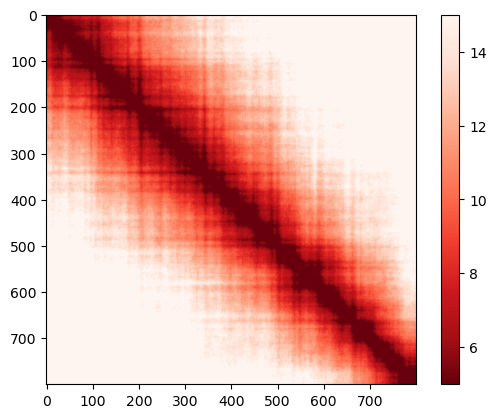

In [39]:
plt.imshow(sample_median_maps[:800, :800], cmap='Reds_r', vmin=5, vmax=15)
plt.colorbar()

In [40]:
sample_contacts = np.array(sample_dmaps) < 12.5

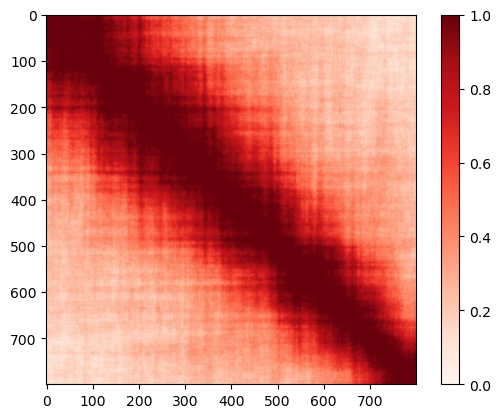

In [41]:
plt.imshow(np.mean(sample_contacts, axis=0)[:800, :800], cmap='Reds', vmin=0, vmax=1)
plt.colorbar()

In [42]:
from scipy.ndimage import zoom

In [43]:
zoom_factor = 0.1
resized_image = zoom(np.mean(sample_contacts, axis=0), zoom_factor)

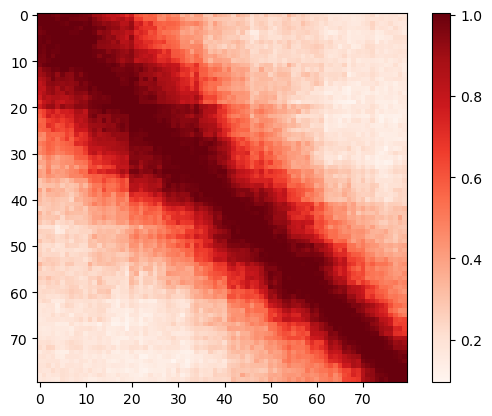

In [44]:
plt.imshow(resized_image[240:320, 240:320], cmap='Reds')
plt.colorbar()

In [45]:
# Load the dataset
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

In [46]:
esc_maps = np.array([squareform(pdist(esc_polys[:80, :, i])) for i in range(esc_polys.shape[2])])
cnc_maps = np.array([squareform(pdist(cnc_polys[:80, :, i])) for i in range(cnc_polys.shape[2])])

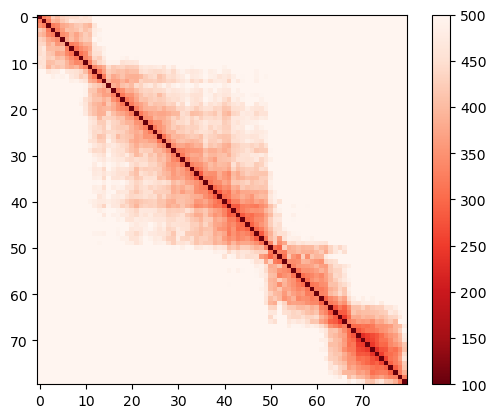

In [47]:
plt.imshow(np.nanmedian(esc_maps, axis=0)[:80, :80], cmap='Reds_r',
           vmin=100, vmax=500)
plt.colorbar()